#Evaluating the ability of a quantum artificial neural network to approximate any arbitrary non-linear multi-variate function

##Background

We begin by asking why is it so pertinent that we even try implement the behaviour of a neural network, and thus a perceptron, on a quantum device? To answer that question we introduce two key aspects that make a quantum device attractive and highlight where exactly this could benefit the field of machine learning.

*   The way data is represented on quantum device can be far more efficent than a classical device. In that, by encoding the data as an amplitude of a bitstring......
*   NOBODY CARES

YADA YADA fill rest in here---

points to be made discuss:

*   why a quantum device is attractive
*   NISQ
*   Variational method - classical and quantum
*   Nonlinearity
*   Satisifies universal function approximation in the exponential circuit depth limit


##Selection of Datasets

As previously discussed the number of features of the dataset can affect the ability of the variational quantum circuit to approximate any arbitrary multivariate function. Here we select a couple of models and retrieve some benchmark results, using classical neural network techniques, for the expected loss function at different epochs.

First we want to asses the ability of the QNN to approximate a non-linear regression model. As this only has one feature we expect that the QNN will give a poor aproximation.

Before we do this lets import all the necessary libraries to run all the models classically.

In [3]:
import torch
import random
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Cleveland Model

####Load and Pre-Process the Data

In [5]:
# Load and preprocess the data
data = pd.read_csv("/content/drive/MyDrive/dataset/Cleveland Dataset.csv")
X = data.drop(columns=["target"])
y = data["target"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [7]:
categorical_headers = ['ca','sex','fbs','restecg','cp','thal','exang','slope']
numeric_headers = ['age','trestbps','chol','thalach','oldpeak']

X_cat = data[categorical_headers]
X_num = data[numeric_headers]

scalerOHE = OneHotEncoder(sparse_output=False)
scalerSS = StandardScaler()

transformer = ColumnTransformer(
    transformers=[
        ('cat', scalerOHE, categorical_headers),
        ('num', scalerSS, numeric_headers),
])

X_train_std = transformer.fit_transform(X_train)
X_test_std = transformer.transform(X_test)

In [8]:
n_features = X_train_std.shape[1]

####Autoencoder

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, bneck_size):

        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size,32),
            nn.ReLU(),
            nn.Linear(32, bneck_size),
        )
        self.decoder = nn.Sequential(
            nn.Linear(bneck_size, 32),
            nn.ReLU(),
            nn.Linear(32,input_size),
            # nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [10]:
BOTTLENECK_SIZE = 9
SEED = 42
LEARNING_RATE = 0.001

In [11]:
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

# Initialize the autoencoder and define the loss function and optimizer
autoencoder = Autoencoder(n_features, BOTTLENECK_SIZE)

criterion = nn.MSELoss()

optimizer = optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)

# Train the model
num_epochs = 700
batch_size = 16
for epoch in range(num_epochs):
    loss_tot=0
    for i in range(0, len(X_train_std), batch_size):
        # Get the batch
        batch_X = torch.FloatTensor(X_train_std[i:i+batch_size])
        optimizer.zero_grad(set_to_none=True)

        # Forward pass
        outputs = autoencoder(batch_X)
        loss =  criterion(outputs, batch_X)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        loss_tot += loss.item()*(len(batch_X))

    loss_tot=loss_tot/len(X_train_std)
    # Print the loss every 10 epochs
    if (epoch+1) % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_tot))

Epoch [100/700], Loss: 0.0519
Epoch [200/700], Loss: 0.0433
Epoch [300/700], Loss: 0.0412
Epoch [400/700], Loss: 0.0401
Epoch [500/700], Loss: 0.0389
Epoch [600/700], Loss: 0.0378
Epoch [700/700], Loss: 0.0371


In [12]:
encoded_data_train = autoencoder.encoder(torch.from_numpy(X_train_std).float()).detach().numpy()
encoded_data_test = autoencoder.encoder(torch.from_numpy(X_test_std).float()).detach().numpy()

###Insurance

####Load Data + Train Test Split

In [17]:
# Load and preprocess the data
ins_df = pd.read_csv("/content/drive/MyDrive/dataset/insurance.csv")
X = ins_df.drop(columns=["charges"])
y = ins_df["charges"]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [19]:
categorical_headers = ['sex','smoker','region','children']
numeric_headers = ['age','bmi']

X_cat = ins_df[categorical_headers]
X_num = ins_df[numeric_headers]

scalerOHE = OneHotEncoder(sparse_output=False)
scalerSS = StandardScaler()

transformer = ColumnTransformer(
    transformers=[
        ('cat', scalerOHE, categorical_headers),
        ('num', scalerSS, numeric_headers),
])

X_train_std = transformer.fit_transform(X_train)
X_test_std = transformer.transform(X_test)

In [137]:
n_features = X_train_std.shape[1]

####Autoencoder

In [22]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, bneck_size):

        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size,32),
            nn.ReLU(),
            nn.Linear(32, bneck_size),
        )
        self.decoder = nn.Sequential(
            nn.Linear(bneck_size, 32),
            nn.ReLU(),
            nn.Linear(32,input_size),
            # nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [10]:
BOTTLENECK_SIZE = 7
SEED = 42
LEARNING_RATE = 0.001

In [23]:
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

# Initialize the autoencoder and define the loss function and optimizer
autoencoder = Autoencoder(n_features, BOTTLENECK_SIZE)

criterion = nn.MSELoss()

optimizer = optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)

# Train the model
num_epochs = 700
batch_size = 16
for epoch in range(num_epochs):
    loss_tot=0
    for i in range(0, len(X_train_std), batch_size):
        # Get the batch
        batch_X = torch.FloatTensor(X_train_std[i:i+batch_size])
        optimizer.zero_grad(set_to_none=True)

        # Forward pass
        outputs = autoencoder(batch_X)
        loss =  criterion(outputs, batch_X)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        loss_tot += loss.item()*(len(batch_X))

    loss_tot=loss_tot/len(X_train_std)
    # Print the loss every 10 epochs
    if (epoch+1) % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_tot))

Epoch [100/700], Loss: 0.0101
Epoch [200/700], Loss: 0.0032
Epoch [300/700], Loss: 0.0018
Epoch [400/700], Loss: 0.0012
Epoch [500/700], Loss: 0.0008
Epoch [600/700], Loss: 0.0007
Epoch [700/700], Loss: 0.0006


In [24]:
encoded_data_train = autoencoder.encoder(torch.from_numpy(X_train_std).float()).detach().numpy()
encoded_data_test = autoencoder.encoder(torch.from_numpy(X_test_std).float()).detach().numpy()
encoded_data_train.shape

(1070, 7)

# Quantum Artificial Neuron

In [28]:
%%capture
try:
    import pennylane as qml
except:
    !pip install pennylane==0.29.1
import pennylane as qml
import jax
import jax.numpy as jnp
import numpy as np
import optax

In [20]:
def embedding(x, wires):
    wires = list(wires)
    qml.templates.AngleEmbedding(x, wires=wires)

def entanglement(wires):
    N = len(wires)

    # circular entanglement chosen
    for i in range(N-1):
        qml.CNOT(wires=[wires[i], wires[i + 1]])
    qml.CNOT(wires=[wires[N-1], wires[0]])


def hardware_efficient_ansatz(theta, wires):
    N = len(wires)

    assert len(theta) == 3 * N
    for i in range(N):
        qml.RX(theta[3 * i], wires=wires[i])
    entanglement(wires)
    for i in range(N):
        qml.RZ(theta[3 * i + 1], wires=wires[i])
    entanglement(wires)
    for i in range(N):
        qml.RX(theta[3 * i + 2], wires=wires[i])
    entanglement(wires)

In [21]:
def get_ansatz(n_qubits):
    return hardware_efficient_ansatz, 3 * n_qubits

In [22]:
def create_circuit(n_qubits,backend,layers,ansatz,ibm_device=None, ibm_token=None):
    if backend == 'jax':
        device = qml.device("default.qubit.jax", wires=n_qubits)
    elif backend == 'ibmq':
        device = qml.device('qiskit.ibmq', wires=n_qubits, backend=ibm_device,
                            ibmqx_token=ibm_token, hub=IBM_QISKIT_HUB,
                            group=IBM_QISKIT_GROUP, project=IBM_QISKIT_PROJECT)
    else:
        raise ValueError(f"Backend {backend} is unknown")
    ansatz, params_per_layer = get_ansatz(n_qubits)

    @qml.qnode(device, interface='jax')
    def circuit(x, theta):

        embedding(x, wires=range(n_qubits))
        for i in range(layers):
            #embedding(x, wires=range(n_qubits))
            ansatz(theta[i * params_per_layer: (i + 1) * params_per_layer], wires=range(n_qubits))
        return [qml.expval(qml.PauliZ(wires=0)),qml.expval(qml.PauliZ(wires=1))]

    return jax.jit(circuit)#

In [23]:
def get_thetas(params):
    def jnp_to_np(value):
        try:
            value_numpy = np.array(value)
            return value_numpy
        except:
            try:
                value_numpy = np.array(value.primal)
                return value_numpy
            except:
                try:
                    value_numpy = np.array(value.primal.aval)
                    return value_numpy
                except:
                    raise ValueError(f"Cannot convert to numpy value {value}")

    return jnp_to_np(params)

In [24]:
@jax.jit
def cross_entropy_loss(y_true, y_pred):
    print(y_true.shape,y_pred.shape)
    return -jnp.mean(jnp.sum(jnp.log(y_pred) * y_true, axis=1))

@jax.jit
def rmse(y_true, y_pred):
    return jnp.sqrt(jnp.mean(jnp.square(y_true - y_pred)))

@jax.jit
def calculate_ce_cost(X, y, theta):
    yp = qnn(X, theta)
    yp = jax.nn.softmax(yp)

    cost = cross_entropy_loss(y, yp)
    #cost = rmse(y, yp)
    return cost

In [25]:
@jax.jit
def calculate_accuracy(X, y, theta):
    yp = qnn(X, theta)
    yp = jax.nn.softmax(yp)
    yp = jnp.argmax(yp, axis=1)
    y = jnp.argmax(y, axis=1)
    total_samples = len(y)
    correct = jnp.sum(y==yp)
    acc = correct/total_samples

    return acc

In [26]:
n_qubits = BOTTLENECK_SIZE
print(f"Using {n_qubits} qubits")

# backend
backend = 'jax'

# layers
layers = 8

# varform
varform = 'hardware_efficient'

#varform = 'ltfim'

# quantum circuit
qnn_tmp = create_circuit(n_qubits, backend, layers, varform)

# apply vmap on x (first circuit param)
qnn_batched = jax.vmap(qnn_tmp, (0, None))

# Jit for faster execution
qnn = jax.jit(qnn_batched)

# optimizer
optimizer = optax.adam(learning_rate=0.04)

runs = 10
epochs = 100

Using 7 qubits


In [39]:
# Optimization update step
@jax.jit
def optimizer_update(opt_state, params, x, y):
    loss, grads = jax.value_and_grad(lambda theta: calculate_ce_cost(x, y, theta))(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

In [29]:
# scalerY = OneHotEncoder(sparse_output=False)
# y_train_ohe = scalerY.fit_transform(y_train.values.reshape(-1,1))
# y_test_ohe = scalerY.transform(y_test)

# y_train_ohe=y_train_ohe.reshape(-1,2)
# y_test_ohe=y_test_ohe.reshape(-1,2)

In [61]:
scaler = StandardScaler()
y_train_std = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_std = scaler.fit_transform(y_train.values.reshape(-1, 1))

# .values.reshape(-1, 1)

y_train_std

array([[-0.3456208 ],
       [-0.40048783],
       [ 1.14633152],
       ...,
       [-0.11777735],
       [ 2.72746075],
       [-0.26065271]])

In [62]:
from sklearn.metrics import accuracy_score


loss = np.zeros(runs)
f1 = np.zeros(runs)

test_acc = np.zeros(runs)
train_acc = np.zeros(runs)

for i in range(runs):

    print(f'run {i}\n')

    # seed
    key = jax.random.PRNGKey(i)

    # get number of circuit params
    _, params_per_layer = get_ansatz(n_qubits)

     # initialize circuit params
    initial_params = jax.random.normal(key, shape=(layers * params_per_layer,))
    #initial_params = jax.random.uniform(key, shape=(layers * params_per_layer,))
    params = jnp.copy(initial_params)

    # initialize optimizer
    opt_state = optimizer.init(initial_params)

    ##### fit #####
    for epoch in range(epochs):
        params, opt_state, cost = optimizer_update(opt_state, params, encoded_data, y_train_std)
        if epoch % 5 == 0:
            print(f'epoch: {epoch} - cost: {cost}')

    # save training time
    #save_dir = full_model_working_dir
    #os.makedirs(save_dir,  0o755,  exist_ok=True)
    #np.save(str(save_dir) + f"/time_training_{i}.npy",end_time_tr)

    # save parameters
    #thetas = get_thetas(params)
    #np.save(str(save_dir) + f"/thetas_{i}.npy", thetas)


    y_predict = qnn(encoded_data, params)
    y_predict = jax.nn.softmax(y_predict)
    y_predict = jnp.argmax(y_predict, axis=1)
    accuracy_score(y_train_std,y_predict)
    print(f'Accuracy of fullmodel on training set: {accuracy_score(y_train_std,y_predict)}\n')
    train_acc[i] = accuracy_score(y_train_std,y_predict)

    y_predict = qnn(encoded_data_test, params)
    y_predict = jax.nn.softmax(y_predict)
    # print(f'Cross entropy loss on test set: {cross_entropy_loss(y_test_ohe,y_predict)}')
    # loss[i] = cross_entropy_loss(y_test_ohe,y_predict)

    #print(f'MSE loss on test set: {rmse(y_test_ohe,y_predict)}')
    #loss[i] = rmse(y_test_ohe,y_predict)
    y_predict = jnp.argmax(y_predict, axis=1)
    #np.save(str(save_dir) + f"/time_test_{i}.npy",end_time_ts)

    # save predictions
    #np.save(str(save_dir) + f"/y_predict_{i}.npy", y_predict)
    print(f'Accuracy of fullmodel on test set: {accuracy_score(y_test_std,y_predict)}\n')
    test_acc[i] = accuracy_score(y_test_std,y_predict)
    f1[i]=f1_score(y_test_std, y_predict)

run 0

epoch: 0 - cost: -8.950991468736902e-05
epoch: 5 - cost: -0.012902406044304371
epoch: 10 - cost: -0.022578969597816467
epoch: 15 - cost: -0.027482006698846817
epoch: 20 - cost: -0.030448144301772118
epoch: 25 - cost: -0.033090293407440186
epoch: 30 - cost: -0.035200830549001694
epoch: 35 - cost: -0.037129100412130356
epoch: 40 - cost: -0.03809389844536781
epoch: 45 - cost: -0.03899216651916504
epoch: 50 - cost: -0.03974692523479462
epoch: 55 - cost: -0.040211353451013565
epoch: 60 - cost: -0.040670834481716156
epoch: 65 - cost: -0.04111037775874138
epoch: 70 - cost: -0.041695572435855865
epoch: 75 - cost: -0.04235554113984108
epoch: 80 - cost: -0.042607713490724564
epoch: 85 - cost: -0.04282226786017418
epoch: 90 - cost: -0.04310515895485878
epoch: 95 - cost: -0.04341292008757591


ValueError: ignored

In [64]:
y_predict


Array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

# TESTS

In [25]:
scaler = StandardScaler()
encoded_target_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
encoded_target_test = scaler.fit_transform(y_train.values.reshape(-1, 1))

In [26]:
n_features = encoded_data_train.shape[1]
layers = 8

In [82]:
dev = qml.device('default.qubit', wires=n_features+1)

In [30]:
@qml.qnode(dev, interface='jax')
def qnn(inputs, weights, n_features, layers):

    assert len(weights) == len(n_features*layers), f"Expected weights of dimension {len(n_features*layers)} got {len(weights)}"

    qml.templates.AngleEmbedding(inputs, wires=range(n_features))
    for i in range(layers):
      qml.templates.BasicEntanglerLayers(weights[i*layers:(i+n_features)*layers], wires=range(n_features))
      qml.templates.AngleEmbedding(inputs, wires=range(n_features))

    return [qml.expval(qml.PauliZ(i)) for i in range(n_features)]

In [83]:
key = jax.random.PRNGKey(i)
weights = jax.random.normal(key, shape=(layers,n_features))

In [84]:
def create_circuit(n_features,layers):

    @qml.qnode(dev,interface='jax')
    def qnn(inputs,weights):
        # assert weights.shape == (layers,3,n_features), f"Expected weights of dimension {n_features*layers} got {len(weights)}"

        qml.Hadamard(wires=[n_features])
        for i in range(n_features):
            qml.CNOT(wires=[n_features,i])

        qml.templates.AngleEmbedding(inputs, wires=range(n_features))
        for i in range(layers):
          qml.templates.BasicEntanglerLayers(weights[i*layers:(i+n_features)*layers], wires=range(n_features))
          qml.templates.AngleEmbedding(inputs, wires=range(n_features))

        for i in range(n_features):
            qml.CNOT(wires=[n_features,i])
        qml.Hadamard(wires=[n_features])

        return [qml.expval(qml.PauliZ(n_features))]

    return jax.jit(qnn)

In [85]:
qnn = create_circuit(n_features,layers)
qnn_batched = jax.vmap(qnn, (0, None))
qnn = jax.jit(qnn_batched)
# optimizer = optax.adam(learning_rate=0.04)

In [34]:
weights.shape

(8, 7)

In [86]:
yp = qnn(encoded_data_train,weights)

Array([1.1920929e-07], dtype=float32)

Array(1.0000099, dtype=float32)

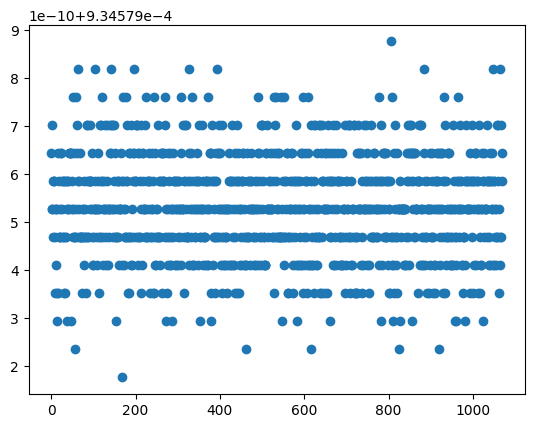

In [113]:
reshaped = yp.reshape(-1,)
plt.scatter(range(len(reshaped)),jax.nn.softmax(reshaped))
sum(jax.nn.softmax(reshaped))

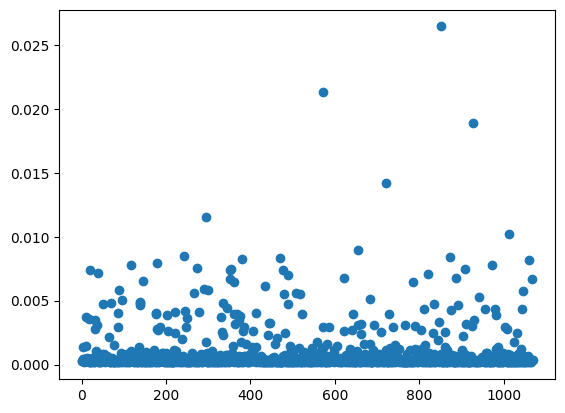

In [72]:
yp = jax.nn.softmax(yp)
ytarget = jax.nn.softmax(y_train.values)
# plt.plot(range(len(ytarget)),ytarget)
# plt.plot(range(len(yp)),yp)
# plt.plot(range(len(ytarget)),ytarget)
# plt.scatter(range(len(y_train.values)),y_train.values)
# plt.scatter(range(len(ytarget)),ytarget)
ypt = encoded_target_train.reshape(1070)
ypt = jax.nn.softmax(ypt)
plt.scatter(range(len(ypt)),ypt)

In [114]:
@jax.jit
def cross_entropy_loss(y_true, y_pred):
    return -jnp.mean(jnp.sum(jnp.log(y_pred) * y_true, axis=1))

@jax.jit
def calculate_ce_cost(X, y, weights):
    yp = qnn(X, weights)
    yp = jax.nn.softmax(yp)
    cost = cross_entropy_loss(y, yp)
    return cost


@jax.jit
def rmse(y_true, y_pred):
    return jnp.sqrt(jnp.mean(jnp.square(y_true - y_pred)))


@jax.jit
def fun_eval(output):
    return jnp.square(output)

In [102]:
# plt.scatter(range(len(reshaped)),rmse(reshaped,ypt))
rmse(reshaped,ypt)

Array(0.00215042, dtype=float32)

In [115]:
@jax.jit
def calculate_ce_cost(X, y, theta):
    yp = qnn(X, theta)
    yp = jax.nn.softmax(yp)
    return rmse(y, yp)


@jax.jit
def optimizer_update(opt_state, weights, X, y):
    loss, grads = jax.value_and_grad(lambda theta: calculate_ce_cost(X, y, theta))(weights)
    updates, opt_state = optimizer.update(grads, opt_state)
    weights = optax.apply_updates(weights, updates)
    return weights, opt_state, loss

In [120]:
import optax
optimizer = optax.adam(learning_rate=1)

In [123]:
key = jax.random.PRNGKey(i)
weights = jax.random.uniform(key, shape=(layers,n_features))
opt_state = optimizer.init(weights)

epochs = 100
for epoch in range(epochs):
        weights, opt_state, cost = optimizer_update(opt_state, weights, encoded_data_train, ypt)
        if epoch % 5 == 0:
            print(f'epoch: {epoch} - cost: {cost}')

epoch: 0 - cost: 0.9990671873092651
epoch: 5 - cost: 0.9990671873092651


KeyboardInterrupt: ignored

In [122]:
loss, grads = jax.value_and_grad(lambda theta: calculate_ce_cost(encoded_data_train, ypt, theta))(weights)
loss, grads

(Array(0.9990672, dtype=float32),
 Array([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]], dtype=float32))

In [124]:
weights

Array([[0.6067487 , 0.5098423 , 0.8208926 , 0.3054459 , 0.35616386,
        0.8490741 , 0.8852092 ],
       [0.10852587, 0.99138594, 0.35130632, 0.59133375, 0.71588385,
        0.8396833 , 0.84017086],
       [0.7399347 , 0.22453916, 0.92689335, 0.5208353 , 0.16784   ,
        0.71321297, 0.7632791 ],
       [0.24437714, 0.6780133 , 0.271039  , 0.9839368 , 0.4462105 ,
        0.38293052, 0.5799098 ],
       [0.89299667, 0.77564955, 0.07950079, 0.44836605, 0.24711609,
        0.7635157 , 0.03121758],
       [0.14479446, 0.99642694, 0.39408767, 0.6768013 , 0.15402198,
        0.68222034, 0.48238766],
       [0.6405988 , 0.0984478 , 0.8683504 , 0.70545757, 0.33602226,
        0.5458468 , 0.2110138 ],
       [0.9009726 , 0.79367065, 0.82090724, 0.5622426 , 0.4536947 ,
        0.70816123, 0.49820268]], dtype=float32)

#TEST 2

In [13]:
%%capture
try:
    import pennylane as qml
except:
    !pip install pennylane==0.29.1
import pennylane as qml
import jax
import jax.numpy as jnp
import numpy as np
import optax

In [ ]:
LAYERS = 8
DEV = qml.device("default.qubit.jax", wires=n_features)

In [151]:
def create_circuit(n_features,layers):

    @qml.qnode(DEV,interface='jax')
    def qnn(inputs,weights):
        # assert weights.shape == (layers,3,n_features), f"Expected weights of dimension {n_features*layers} got {len(weights)}"

        # qml.Hadamard(wires=[n_features])
        # for i in range(n_features):
        #     qml.CNOT(wires=[n_features,i])

        qml.templates.AngleEmbedding(inputs, wires=range(n_features))
        for i in range(layers):
          qml.templates.BasicEntanglerLayers(weights[i*layers:(i+n_features)*layers], wires=range(n_features))
          qml.templates.AngleEmbedding(inputs, wires=range(n_features))

        # for i in range(n_features):
        #     qml.CNOT(wires=[n_features,i])
        # qml.Hadamard(wires=[n_features])

        return [qml.expval(qml.PauliZ(wires=0)),qml.expval(qml.PauliZ(wires=1))]

    return jax.jit(qnn)